✅ Image loaded and binarized using Otsu's method (/content/coins.jpg)
DISTANCE TRANSFORM ANALYSIS


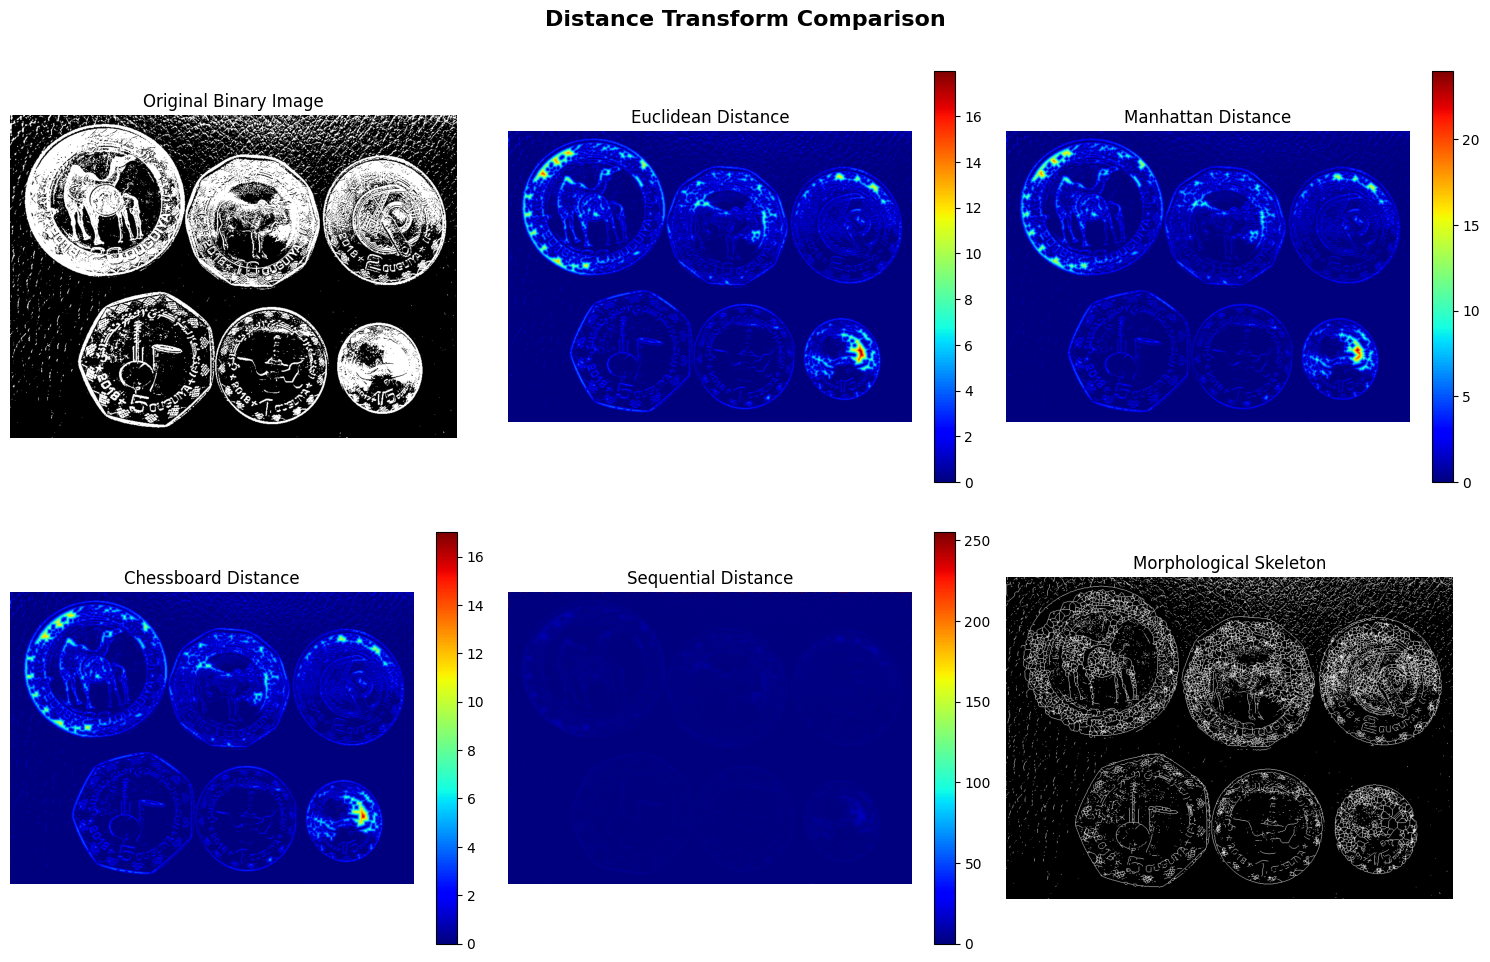

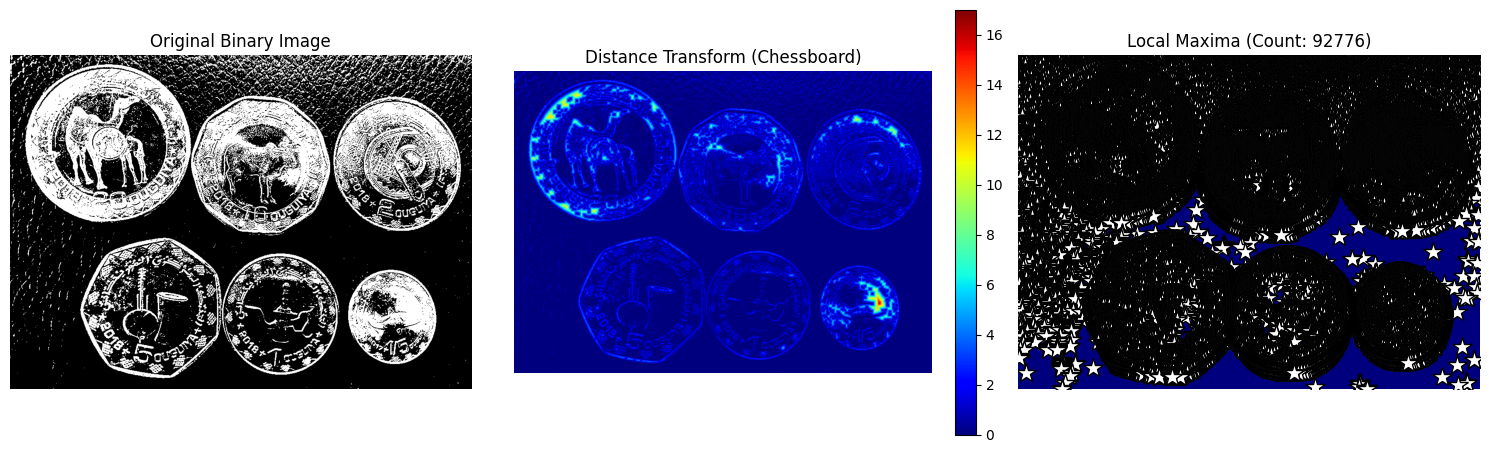

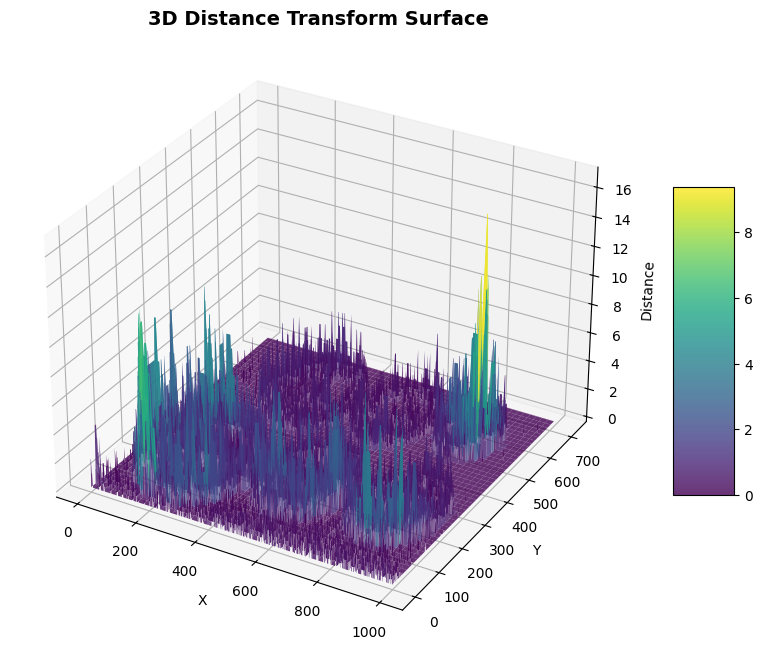


STATISTICS
Number of local maxima: 92776
Maximum distance value: 17.00
Mean distance value: 1.80


In [3]:
# ============================================
# DISTANCE TRANSFORM VISUALIZATION (Single Image)
# ============================================

# Step 1: Install and Import Libraries
# ============================================
!pip install opencv-python-headless scikit-image

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology
from PIL import Image

# ============================================
# Step 2: Distance Transform Functions
# ============================================

def distance_transform_sequential(binary_img):
    """Sequential distance transform algorithm"""
    Q = np.where(binary_img > 0, 255, 0).astype(np.uint8)
    N = 0
    max_iterations = 100

    while max_iterations > 0:
        changed = False
        temp_Q = Q.copy()
        for i in range(1, Q.shape[0] - 1):
            for j in range(1, Q.shape[1] - 1):
                if Q[i, j] == 255:
                    neighbors = [
                        Q[i-1, j-1], Q[i-1, j], Q[i-1, j+1],
                        Q[i, j-1],              Q[i, j+1],
                        Q[i+1, j-1], Q[i+1, j], Q[i+1, j+1]
                    ]
                    if N in neighbors:
                        temp_Q[i, j] = N + 1
                        changed = True
        Q = temp_Q
        if not changed:
            break
        N += 1
        max_iterations -= 1
    return Q


def compute_distance_transforms(binary_img):
    """Compute distance transforms using multiple methods"""
    dist_euclidean = cv2.distanceTransform(binary_img, cv2.DIST_L2, 5)
    dist_manhattan = cv2.distanceTransform(binary_img, cv2.DIST_L1, 3)
    dist_chessboard = cv2.distanceTransform(binary_img, cv2.DIST_C, 3)
    dist_sequential = distance_transform_sequential(binary_img)
    return {
        'Euclidean': dist_euclidean,
        'Manhattan': dist_manhattan,
        'Chessboard': dist_chessboard,
        'Sequential': dist_sequential
    }

# ============================================
# Step 3: Visualization Helpers
# ============================================

def find_local_maxima(dist_transform):
    local_max = ndimage.maximum_filter(dist_transform, size=3)
    maxima = (dist_transform == local_max) & (dist_transform > 0)
    coords = np.argwhere(maxima)
    return maxima, coords

def compute_skeleton(binary_img):
    skeleton = morphology.skeletonize(binary_img > 0)
    return skeleton.astype(np.uint8) * 255

def visualize_distance_transform(binary_img, dist_transforms):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Distance Transform Comparison', fontsize=16, fontweight='bold')

    axes[0, 0].imshow(binary_img, cmap='gray')
    axes[0, 0].set_title('Original Binary Image')
    axes[0, 0].axis('off')

    methods = ['Euclidean', 'Manhattan', 'Chessboard', 'Sequential']
    positions = [(0, 1), (0, 2), (1, 0), (1, 1)]
    for method, pos in zip(methods, positions):
        im = axes[pos].imshow(dist_transforms[method], cmap='jet')
        axes[pos].set_title(f'{method} Distance')
        axes[pos].axis('off')
        plt.colorbar(im, ax=axes[pos], fraction=0.046)

    skeleton = compute_skeleton(binary_img)
    axes[1, 2].imshow(skeleton, cmap='gray')
    axes[1, 2].set_title('Morphological Skeleton')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_local_maxima(binary_img, dist_transform):
    maxima, coords = find_local_maxima(dist_transform)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(binary_img, cmap='gray')
    axes[0].set_title('Original Binary Image')
    axes[0].axis('off')

    im = axes[1].imshow(dist_transform, cmap='jet')
    axes[1].set_title('Distance Transform (Chessboard)')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)

    axes[2].imshow(dist_transform, cmap='jet')
    axes[2].plot(coords[:, 1], coords[:, 0], 'w*', markersize=15,
                 markeredgecolor='black', markeredgewidth=1)
    axes[2].set_title(f'Local Maxima (Count: {len(coords)})')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    return coords

def create_3d_visualization(dist_transform):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = np.arange(dist_transform.shape[1])
    y = np.arange(dist_transform.shape[0])
    X, Y = np.meshgrid(x, y)

    surf = ax.plot_surface(X, Y, dist_transform, cmap='viridis',
                           edgecolor='none', alpha=0.8)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Distance')
    ax.set_title('3D Distance Transform Surface', fontsize=14, fontweight='bold')

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# ============================================
# Step 4: Run Analysis on Your Image
# ============================================

def analyze_shape(binary_img):
    print("=" * 60)
    print("DISTANCE TRANSFORM ANALYSIS")
    print("=" * 60)

    dist_transforms = compute_distance_transforms(binary_img)
    visualize_distance_transform(binary_img, dist_transforms)

    dist_chessboard = dist_transforms['Chessboard']
    coords = visualize_local_maxima(binary_img, dist_chessboard)
    create_3d_visualization(dist_chessboard)

    print("\n" + "=" * 60)
    print("STATISTICS")
    print("=" * 60)
    print(f"Number of local maxima: {len(coords)}")
    print(f"Maximum distance value: {dist_chessboard.max():.2f}")
    print(f"Mean distance value: {dist_chessboard[binary_img > 0].mean():.2f}")
    print("=" * 60)

# ============================================
# Step 5: Load and Process /content/coins.jpg
# ============================================

def process_image_from_path(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Error: Could not read image from path:", image_path)
        return

    # Use Otsu thresholding (better for real images)
    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    print(f"✅ Image loaded and binarized using Otsu's method ({image_path})")

    analyze_shape(binary_img)

# ============================================
# RUN ANALYSIS
# ============================================

process_image_from_path("/content/coins.jpg")
